In [1]:
import pylab as plt
import os.path as op
path_data = op.abspath('./data/')
%matplotlib inline

> credits: originally by Gael Varoquaux
> 
> adapted by: Chris Holdgraf

# About this tutorial
This is a quick introduction to doing neuroimaging machine learning with `nilearn`. It covers the following topics:

* Loading a neuroimaging dataset suitable for decoding
* Extracting an ROI and vectorizing our 3D data so it may be passed to a `sklearn` object
* Using pandas to munge some data
* Fitting a `sklearn` classifier on our neuroimaging data
* Visualizing classifier weights on the subject's brain

Note: A lot of the material in this tutorial is drawn from the `nilearn` collection of examples. Open-source packages can be a great way to learn both about a package, and about the things that package tries to do (e.g., machine learning).

In addition, many `nilearn` developers have recently released a paper covering the topics of decoding brain states with fMRI (and other modalities).

* [Link to original `nilearn` tutorial](https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html#sphx-glr-auto-examples-plot-decoding-tutorial-py)
* [Link to Varoquaux decoding paper](https://arxiv.org/pdf/1606.05201v2.pdf)

# A introduction tutorial to fMRI decoding
Thus far we've covered the general topics of machine learning, but how do they apply specifically to neuroscience data? There are many packages that have been designed to leverage the power of machine learning for the specific problems we attempt to solve in neuroscience. One excellent package is called `nilearn`, which focuses on neuroimaging.

This is a simple tutorial on decoding with nilearn. It reproduces the
Haxby 2001 study on a face vs cat discrimination task in a mask of the
ventral stream. We'll cover some basics of how to represent neuroimaging data in python, as well as some high-level functions that allow you to decode experimental conditions with this data.

* [Here's a link](http://www.pymvpa.org/datadb/haxby2001.html) to the Haxby 2001 Dataset (w/ a link to the paper too)

# Retrieve and load the fMRI data from the  Haxby study

## First download the data

The `nilearn.datasets.fetch_haxby` function will download the
Haxby dataset if it's not present on the disk. It'll put this in the `nilearn` data directory and only needs to be downloaded once.

In [1]:
from nilearn import datasets
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby(data_dir=path_data)
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      fmri_filename)  # 4D data


Dataset created in /home/jovyan/nilearn_data/haxby2001



Downloaded 2969 of 2969 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 408 of 408 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 314803244 of 314803244 bytes (100.0%,    0.0s remaining) ...done. (39 seconds, 0 min)
Extracting data from /home/jovyan/nilearn_data/haxby2001/b7061e6dfd4459484ab7c3872d37e765/subj1-2010.01.14.tar.gz..... done.


First subject functional nifti images (4D) are at: /home/jovyan/nilearn_data/haxby2001/subj1/bold.nii.gz


## Convert the fMRI volume's to a data matrix
As we saw in the previous lecture, we can easily load volume data into python using `nibabel`. However, we generally don't want the full volume, but instead prefer to use a subset of voxels based on some preferred region of the brain (e.g. the cortical surface). `nilearn` allows us to do this easily, turning the 4-D matrix of into an array of shape (n_samples, n_features). This allows us to use scikit-learn to do machine learning.

We will use the `nilearn.input_data.NiftiMasker` to extract the
fMRI data on a mask and convert it to data series.

The mask is a mask of the Ventral Temporal streaming coming from the
Haxby study:



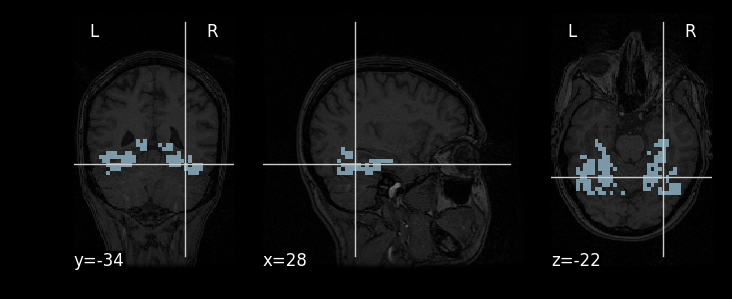

In [2]:
mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a
# background
from nilearn import plotting
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                  cmap='Paired')

This shows us which voxels will be extracted with the mask. Now we use the NiftiMasker.

We first create a masker, giving it the options that we care
about. Here we use standardizing of the data, as it is often important
for decoding. This scales the data so that its mean / variance is more consistent across voxels.

In [3]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_filename, standardize=True)

# We give the masker a filename and retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_filename)

The variable "fmri_masked" is a numpy array:



In [4]:
print(fmri_masked)

[[-2.25146627  1.11008501 -0.38940424 ..., -1.31005859 -0.82755452
   1.04562497]
 [-1.99929178  0.90351063 -0.78263468 ..., -1.76820636 -0.66073179
  -0.30779985]
 [-1.72771943  0.8471722  -0.71709627 ..., -1.16538048 -1.11570287
   0.35240737]
 ..., 
 [ 0.28967512 -1.70683813 -2.66686344 ...,  1.28209257  1.0074954
   1.24368715]
 [ 0.75522774 -1.61294067 -2.8307097  ...,  1.71612716  1.37147236
   1.07863522]
 [ 0.17328696 -1.59416115 -2.71601725 ...,  1.58350551  1.56862628
   1.57379067]]


Its shape corresponds to the number of time-points x the number of
voxels in the mask

In [5]:
print(fmri_masked.shape)

(1452, 577)


## Load the behavioral labels

The behavioral labels are stored in a CSV file, separated by spaces.

We use numpy to load them in an array.

In [6]:
import pandas as pd
import numpy as np
# Load target information as string and give a numerical identifier to each
labels = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
print(labels.head())

  labels  chunks
0   rest       0
1   rest       0
2   rest       0
3   rest       0
4   rest       0


Retrieve the behavioral targets, that we are going to predict in the
decoding



In [7]:
print(labels['labels'].values)

['rest' 'rest' 'rest' ..., 'rest' 'rest' 'rest']


## Restrict the analysis to cats and faces

As we can see from the targets above, the experiment contains many
conditions, not all that interest us for decoding.

To keep only data corresponding to faces or cats, we create a
mask of the samples belonging to the condition.



In [8]:
condition_mask = labels.eval('labels in ["face", "cat"]').values
# condition_mask = np.logical_or(target == b'face', target == b'cat')

# We apply this mask in the sampe direction to restrict the
# classification to the face vs cat discrimination
fmri_masked = fmri_masked[condition_mask]

We now have less samples



In [9]:
print(fmri_masked.shape)

(216, 577)


We apply the same mask to the targets



In [10]:
targets = labels[condition_mask]['labels'].values
print(targets.shape)

(216,)


## Decoding with an SVM

As before, we'll use the [scikit-learn](http://www.scikit-learn.org>)  toolbox on the fmri_masked data.

As a decoder, we'll use a Support Vector Classification, with a linear
kernel.

In [11]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
print(svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


The svc object is an object that can be fit (or trained) on data with
labels, and then predict labels on data without.

We first fit it on the data



In [12]:
svc.fit(fmri_masked, targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We can then predict the labels from the data



In [13]:
prediction = svc.predict(fmri_masked)
print(prediction)

['face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' '

Let's measure the error rate:



In [14]:
print((prediction == targets).sum() / float(len(targets)))

1.0


This error rate is meaningless. Why?



# Measuring prediction scores using cross-validation

The proper way to measure error rates or prediction accuracy is via
cross-validation: leaving out some data and testing on it.

## Manually leaving out data

Let's leave out the 30 last data points during training, and test the
prediction on these 30 last points:



In [15]:
svc.fit(fmri_masked[:-30], targets[:-30])

prediction = svc.predict(fmri_masked[-30:])
print((prediction == targets[-30:]).sum() / float(len(targets[-30:])))

0.633333333333


## Implementing a KFold loop


We can split the data in train and test set repetitively in a `KFold`
strategy. We can create many cross-validation objects with `sklearn`. When one iterates through these, it returns different indices for training / test sets upon teach iteration.



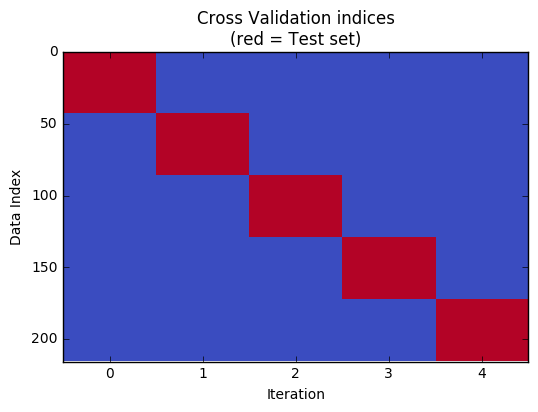

In [18]:
from sklearn.cross_validation import KFold

cv = KFold(n=len(fmri_masked), n_folds=5)

cv_sample = np.zeros([len(fmri_masked), 5])
for ii, (tr,tt) in enumerate(cv):
    cv_sample[tt, ii] = 1
fig, ax = plt.subplots()
ax.imshow(cv_sample, cmap='coolwarm', aspect='auto', interpolation='nearest')
_ = ax.set(xlabel='Iteration', ylabel='Data Index',
           title='Cross Validation indices\n(red = Test set)')

In this way, we can easily fit / validate the model on different subsets of data:

In [19]:
for train, test in cv:
    svc.fit(fmri_masked[train], targets[train])
    prediction = svc.predict(fmri_masked[test])
    print((prediction == targets[test]).sum() / float(len(targets[test])))

0.727272727273
0.46511627907
0.720930232558
0.581395348837
0.744186046512


Also note that `sklearn` has tools to perform cross-validation more easily:

In [20]:
from sklearn.cross_validation import cross_val_score
cv_score = cross_val_score(svc, fmri_masked, targets)
print(cv_score)

[ 0.625       0.52777778  0.68055556]


Note that we can speed things up to use all the CPUs of our computer
with the n_jobs parameter.

By default, cross_val_score uses a 3-fold KFold. We can control this by
passing the "cv" object, here a 5-fold:



In [21]:
cv_score = cross_val_score(svc, fmri_masked, targets, cv=cv)
print(cv_score)

[ 0.72727273  0.46511628  0.72093023  0.58139535  0.74418605]


The best way to do cross-validation is to respect the structure of
the experiment, for instance by leaving out full sessions of
acquisition.

The number of the session is stored in the CSV file giving the
behavioral data. We have to apply our session mask, to select only cats
and faces. To leave a session out, we pass it to a
LeaveOneLabelOut object:



In [22]:
session_label = labels['chunks'][condition_mask]

from sklearn.cross_validation import LeaveOneLabelOut
cv = LeaveOneLabelOut(session_label)
cv_score = cross_val_score(svc, fmri_masked, targets, cv=cv)
print(cv_score)

[ 1.          0.61111111  0.94444444  0.88888889  0.88888889  0.94444444
  0.72222222  0.94444444  0.5         0.72222222  0.5         0.55555556]


# Inspecting the model weights


Finally, it may be useful to inspect and display the model weights.

## Turning the weights into a nifti image

We retrieve the SVC discriminating weights



In [23]:
coef_ = svc.coef_
print(coef_)

[[ -4.03108891e-02  -3.49412808e-02  -1.70223087e-02  -3.42159057e-03
   -2.33893667e-02  -1.22940103e-02  -2.79866312e-02  -1.52685970e-02
   -1.36452221e-02  -3.23905377e-02  -2.26553880e-03  -6.13453888e-02
   -2.50680842e-02   2.41239333e-02  -3.97237046e-02   2.46573345e-02
   -2.67997500e-02  -2.41813969e-02  -5.66277288e-02  -1.62779798e-02
    3.59979712e-03  -3.51138649e-03  -2.19785252e-02  -1.03746823e-02
    3.41675262e-02  -6.03516535e-04  -3.16508567e-02  -1.26717950e-02
   -2.68206252e-02   1.56282120e-02  -4.60449159e-02  -3.08783179e-02
   -3.09531222e-02  -2.60623211e-02  -4.04018099e-02  -1.91451953e-02
   -1.79200521e-02   4.20827401e-04  -1.63643999e-04   1.28799775e-02
   -2.14542008e-02  -3.79804039e-02   3.47548934e-03  -2.27829740e-02
    1.05304886e-02   5.10571035e-02  -5.96033709e-02  -1.21514715e-02
   -1.32891972e-02   2.74404987e-03  -2.64419989e-02  -2.72180564e-02
    9.81565551e-03  -2.28569302e-02   1.79850222e-02   5.12699359e-03
    2.26668770e-02  

It's a numpy array



In [24]:
print(coef_.shape)

(1, 577)


We need to turn it back into a Nifti image, in essence, "inverting"
what the NiftiMasker has done.

For this, we can call inverse_transform on the NiftiMasker:

In [25]:
coef_img = masker.inverse_transform(coef_)
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (40, 64, 64, 1)
affine: 
[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 40 64 64  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.    3.5   3.75  3.75  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_f

coef_img is now a NiftiImage.

We can save the coefficients as a nii.gz file:

In [26]:
coef_img.to_filename('haxby_svc_weights.nii.gz')

## Plotting the SVM weights

Finally, we can plot the weights that the model found, using the subject's anatomical as a background.

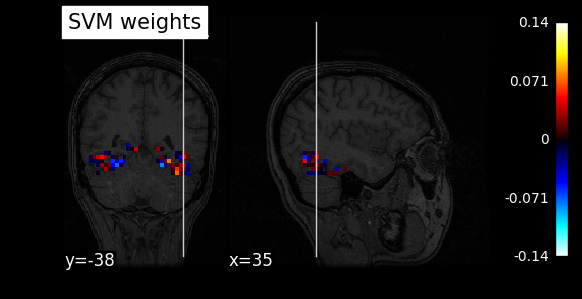

In [27]:
from nilearn.plotting import plot_stat_map, show

plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
              title="SVM weights", display_mode="yx")

show()

Further reading
----------------

* The `section of the documentation on decoding <decoding_tutorial>`

* `sphx_glr_auto_examples_02_decoding_plot_haxby_anova_svm.py`

* `space_net`

